In [34]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.model import Discriminator
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from torch import optim
from torch import nn
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
import seaborn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def calculate_metrics(predictions, labels):
    # Convert predictions and labels to numpy arrays
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')  # Change 'weighted' to 'micro', 'macro', or 'samples'
    recall = recall_score(labels, predictions, average='weighted')  # Change 'weighted' to 'micro', 'macro', or 'samples'
    f1 = f1_score(labels, predictions, average='weighted')  # Change 'weighted' to 'micro', 'macro', or 'samples'

    # Calculate confusion matrix
    cm = confusion_matrix(labels, predictions)

    return accuracy, precision, recall, f1, cm

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Real cells

In [3]:
args_real = {
    # TASK NAME
    'task_name': 'rxrx1_batch',

    # IMAGE
    'img_size': 96,
    'latent_dim': 100,
    'hidden_dim': 512,
    'style_dim': 64,
    'stochastic': True,
    'z_dimension': 10,
    'dim_in': 64,
    'pert_modelling': False,
    'batch_key': 'BATCH',
    'subsample_frac': 1.0,

    # LOSS
    'lambda_reg': 1,
    'lambda_cyc': 1,
    'lambda_sty': 1,
    'lambda_ds': 1,

    # TRAINING
    'total_epochs': 100,
    'ds_iter': 100000,
    'resume_iter': 0,
    'batch_size': 64,
    'val_batch_size': 64,
    'lr': 0.0001,
    'f_lr': 0.0001,
    'beta1': 0,
    'beta2': 0.99,
    'weight_decay': 0.0001,
    'num_outs_per_domain': 10,
    'single_style': True,
    'ood_set': None,
    'mol_list': None,
    'balanced': False,
    'trainable_emb': True,
    'dataset_name': 'rxrx1',
    'n_channels': 6,
    'num_workers': 6,
    'seed': 42,

    # DIRECTORIES FOR DATA
    'image_path': '/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1',
    'data_index_path': '/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv',
    'embedding_path': None,

    # # DIRECTORIES FOR RESULTS
    'experiment_directory': '../project_folder/experiments/',
    'sample_dir': 'sample',
    'checkpoint_dir': 'checkpoint',
    'basal_vs_real_folder': 'basal_vs_real',
    'naming_key': 'dataset_name',
    'embedding_folder': 'embeddings',
    'resume_dir': '',

    # DATA HANDLEMENT
    'augment_train': True,
    'normalize': True,

    # LOGGING INFO
    'print_every': 10,
    'sample_every': 1000,
    'save_every': 500,
    'eval_every': 500,

    # PARAMETERS FOR CONDITION ENCODING
    'encode_rdkit': True,
    'num_layers_mapping_net': 1,
}

args_real = OmegaConf.create(args_real)
dataloader_real = CellDataLoader(args_real)
real_prediction_set = [dataloader_real.train_dataloader(), 
                          dataloader_real.val_dataloader()]

# Generated cells

In [4]:
args_generated = {
    # TASK NAME
    'task_name': 'rxrx1_batch',

    # IMAGE
    'img_size': 96,
    'latent_dim': 100,
    'hidden_dim': 512,
    'style_dim': 64,
    'stochastic': True,
    'z_dimension': 10,
    'dim_in': 64,
    'pert_modelling': False,
    'batch_key': 'BATCH',
    'subsample_frac': 1.0,

    # LOSS
    'lambda_reg': 1,
    'lambda_cyc': 1,
    'lambda_sty': 1,
    'lambda_ds': 1,

    # TRAINING
    'total_epochs': 100,
    'ds_iter': 100000,
    'resume_iter': 0,
    'batch_size': 64,
    'val_batch_size': 64,
    'lr': 0.0001,
    'f_lr': 0.0001,
    'beta1': 0,
    'beta2': 0.99,
    'weight_decay': 0.0001,
    'num_outs_per_domain': 10,
    'single_style': True,
    'ood_set': None,
    'mol_list': None,
    'balanced': False,
    'trainable_emb': True,
    'dataset_name': 'rxrx1',
    'n_channels': 6,
    'num_workers': 6,
    'seed': 42,

    # DIRECTORIES FOR DATA
    'image_path': '/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1_transported',
    'data_index_path': '/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv',
    'embedding_path': None,

    # # DIRECTORIES FOR RESULTS
    'experiment_directory': '../project_folder/experiments/',
    'sample_dir': 'sample',
    'checkpoint_dir': 'checkpoint',
    'basal_vs_real_folder': 'basal_vs_real',
    'naming_key': 'dataset_name',
    'embedding_folder': 'embeddings',
    'resume_dir': '',

    # DATA HANDLEMENT
    'augment_train': True,
    'normalize': True,

    # LOGGING INFO
    'print_every': 10,
    'sample_every': 1000,
    'save_every': 500,
    'eval_every': 500,

    # PARAMETERS FOR CONDITION ENCODING
    'encode_rdkit': True,
    'num_layers_mapping_net': 1,
}
args_generated = OmegaConf.create(args_generated)
dataloader_generated = CellDataLoader(args_generated)
generated_prediction_set = [dataloader_generated.train_dataloader(), 
                              dataloader_generated.val_dataloader()]

## Initialize Discriminator

In [5]:
dataloader_generated.n_mol

3

In [6]:
classifier_net = Discriminator(img_size=96,
                                  num_domains=dataloader_generated.n_mol, 
                                  max_conv_dim=512, 
                                  in_channels=6, 
                                  dim_in=64,
                                  multi_task=False)

In [7]:
class Classifier(LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x, None)

    def training_step(self, batch, batch_idx):
        X, labels = batch["X"], batch["mol_one_hot"].argmax(1)
        outputs = self.model(X, None)
        loss = self.criterion(outputs, labels)
        return loss

    def val_step(self, batch, batch_idx):
        X, labels = batch["X"], batch["mol_one_hot"].argmax(1)
        outputs = self.model(X, None)
        loss = self.criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).sum().item() / len(labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.val_step(batch, batch_idx)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss = self.val_step(batch, batch_idx)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)


In [8]:
classifier = Classifier(classifier_net, 0.0001)
classifier.to("cuda")

Classifier(
  (model): Discriminator(
    (conv): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResBlk(
        (actv): LeakyReLU(negative_slope=0.2)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1x1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (2): ResBlk(
        (actv): LeakyReLU(negative_slope=0.2)
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1x1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (3): ResBlk(
        (actv): LeakyReLU(negative_slope=0.2)
        (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1,

In [9]:
classifier.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/batch_classifier_results/rxrx1/best_model.ckpt")["state_dict"])

<All keys matched successfully>

Prediction Real cells

In [10]:
true_labels_real = []
predicted_labels_real = []
for set in real_prediction_set:
    for batch in tqdm(set):
        with torch.no_grad():
            X = batch["X"].to("cuda")
            pred = classifier(X)
            predicted_labels_real.append(pred.argmax(1).cpu())
            true_labels_real.append(batch["mol_one_hot"].argmax(1).cpu())

100%|██████████| 536/536 [01:29<00:00,  6.01it/s]


In [11]:
true_labels_real=torch.cat(true_labels_real)
predicted_labels_real=torch.cat(predicted_labels_real)

In [12]:
calculate_metrics(true_labels_real, predicted_labels_real)

(0.9985726236230791,
 0.9985728811606257,
 0.9985726236230791,
 0.9985726043942695,
 array([[56280,     1,   147],
        [    1, 57755,     0],
        [   92,     3, 56664]]))

Prediction generated cells 

In [13]:
true_labels_generated= []
predicted_labels_generated = []
for set in generated_prediction_set:
    for batch in tqdm(set):
        with torch.no_grad():
            X = batch["X"].to("cuda")
            pred = classifier(X)
            predicted_labels_generated.append(pred.argmax(1).cpu())
            true_labels_generated.append(batch["mol_one_hot"].argmax(1).cpu())

100%|██████████| 536/536 [01:12<00:00,  7.35it/s]


In [14]:
true_labels_generated=torch.cat(true_labels_generated)
predicted_labels_generated=torch.cat(predicted_labels_generated)

In [15]:
calculate_metrics(true_labels_generated, predicted_labels_generated)

(0.3332865341078605,
 0.9875873001693133,
 0.3332865341078605,
 0.4927285338422813,
 array([[56086, 57587, 55996],
        [   27,    96,    24],
        [  260,    76,   791]]))

## Plot results

In [39]:
batch_before, freq_before = np.unique(predicted_labels_real.tolist(), return_counts=True)
batch_after, freq_after = np.unique(predicted_labels_generated.tolist(), return_counts=True)

batch = list(batch_before) + list(batch_after)
batch = [f"batch {key}" for key in batch]
freq = list(freq_before) + list(freq_after)

method = ["Before transformation"]*len(batch_before) + ["After transformation"]*len(batch_before) 

In [40]:
to_plot = pd.DataFrame({"Batch": batch, 
                        "Freq": freq, 
                           "Method": method})

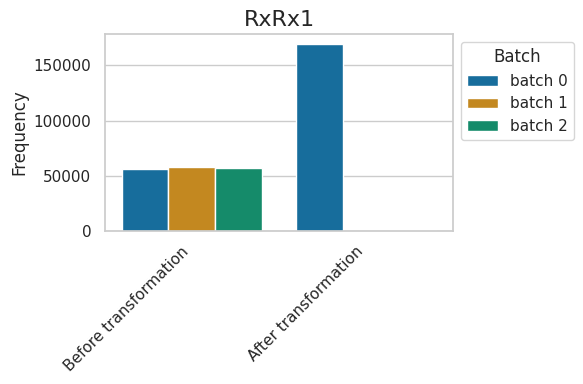

In [76]:
# Set the style for a cleaner appearance
sns.set(style="whitegrid")

# Set the figure size
plt.figure(figsize=(6, 4))

# Plot the bar chart
sns.barplot(data=to_plot, 
            x="Method", 
            y="Freq", 
            hue="Batch", 
            palette="colorblind",
            ci=None)  # Set ci=None to remove error bars if not needed

# Add labels and title
plt.xlabel("Method", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("RxRx1", fontsize=16)

# Move the legend outside the plot for better visibility
plt.legend(title="Batch", loc="upper left", bbox_to_anchor=(1, 1))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")
plt.xlabel("")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
batch_before

In [ ]:
freq_before